In [3]:
import pandas as pd
import matplotlib as pyplt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys


In [4]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [ ]:
train_df.drop(columns=['Id'], inplace=True)
test_df.drop(columns=['Id'],inplace=True)


In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [19]:
from sklearn.impute import SimpleImputer
#Missing values
Missing_values=train_df.isnull().sum()
print('Missing values:')
print(Missing_values)

#replace: for numbers to be median and categorical features to most frequent value (Median)
num_features=train_df.select_dtypes(include=['int64','float64']).columns.drop('SalePrice')
cat_features=train_df.select_dtypes(include='object').columns

num_imputer=SimpleImputer(strategy='median')
cat_imputer=SimpleImputer(strategy='most_frequent')

Missing values:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [20]:
# Convert the categorical values to numerical
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_imputer, num_features),
        ('cat', Pipeline([('imputer', cat_imputer), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
    ]
)

In [21]:
y=train_df['SalePrice']
x=train_df.drop(columns=['SalePrice'])
x=preprocessor.fit_transform(x)

In [23]:
#split the data into train and test sets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [56]:
#Standardscaler makes the numerical feature have mean=0 and standard deviation=1 so that all the models work better
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(num_imputer.fit_transform(x_train[num_features]))
x_test_scaled=scaler.transform(num_imputer.transform(x_test[num_features]))


TypeError: '>=' not supported between instances of 'str' and 'int'

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(kernel='rbf'),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'K Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
}

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the results dictionary
results = {}

# Train and evaluate each model
def train_and_evaluate (model,x_train,x_test,y_train,y_test,scale=False):
    if scale:#if we need scaling and we got it done then  training the model accordingly
        model.fit(x_train_scaled,y_train)
        y_pred=model.predict(x_test_scaled)
    else:#if we don't need it
        model.fit(x_train,y_train)
        y_pred=model.predict(x_test)

    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    r2=r2_score(y_test,y_pred)


    results[model.__class__.__name__]= {'MAE':mae,'MSE':mse,'RMSE':rmse,'R2':r2}

    print(f'{model.__class__.__name__}')
    print("Performance: ")
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')

In [32]:
for name, model in models.items():
    train_and_evaluate(model,x_train,x_test,y_train,y_test,scale=(name in ['Support Vector Regression','K Nearest Neighbors']))
    

LinearRegression
Performance: 
MAE: 20491.89572619332
MSE: 982605052.283354
RMSE: 31346.531742496714
R2: 0.8718952720208106
SVR
Performance: 
MAE: 59556.78002476839
MSE: 7859369608.014615
RMSE: 88653.08572190037
R2: -0.02464607054786727
RandomForestRegressor
Performance: 
MAE: 17758.576883561644
MSE: 872119068.1926394
RMSE: 29531.662130544555
R2: 0.8862996116937686
KNeighborsRegressor
Performance: 
MAE: 23351.956164383562
MSE: 1578926011.240274
RMSE: 39735.70197241108
R2: 0.7941513869695902


In [33]:
result_df=pd.DataFrame(results).T

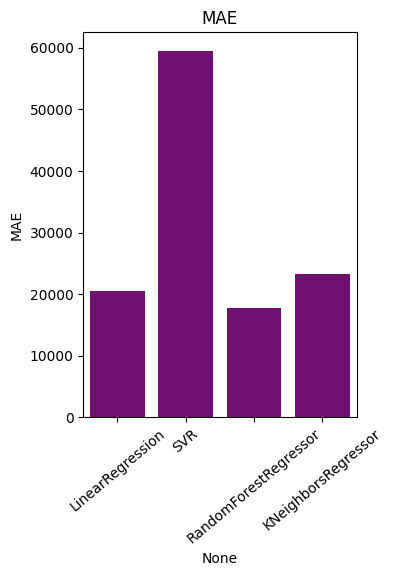

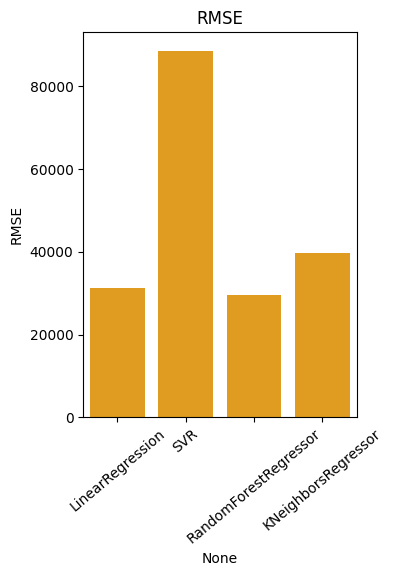

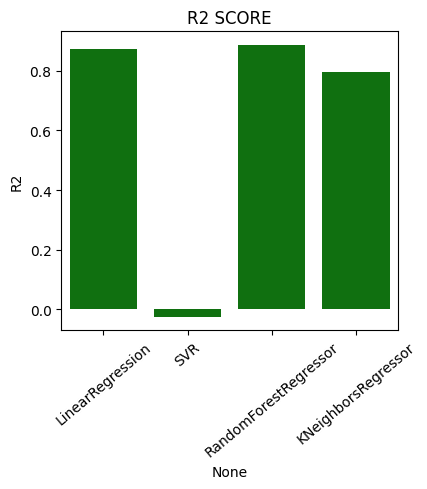

In [46]:
#plotting the results
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.barplot(x=result_df.index,y=result_df['MAE'],color='purple')
plt.title('MAE')
plt.xticks(rotation=40)

plt.figure(figsize=(12,5))
plt.subplot(1,3,2)
sns.barplot(x=result_df.index,y=result_df['RMSE'],color='orange')
plt.title('RMSE')
plt.xticks(rotation=40)

plt.figure(figsize=(12,5))
plt.subplot(1,3,3)
sns.barplot(x=result_df.index,y=result_df['R2'],color='green')
plt.title('R2 SCORE')
plt.xticks(rotation=40)

plt.tight_layout()
plt.show()



Text(0, 0.5, 'Predictions')

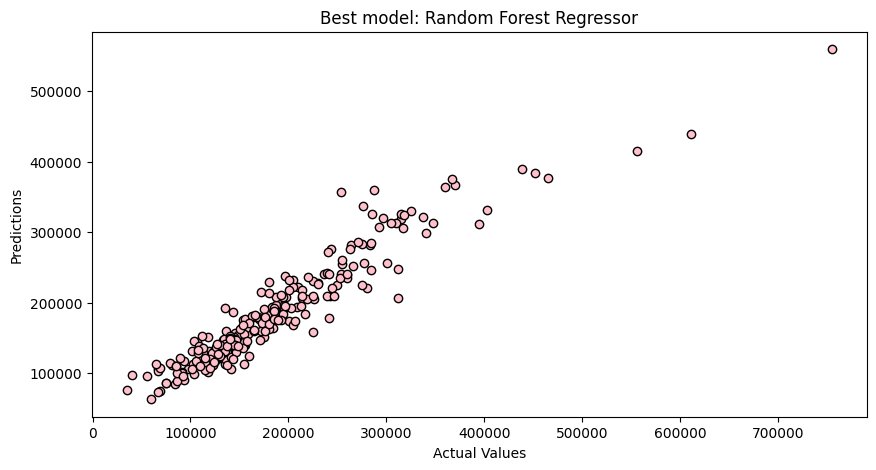

In [55]:
best_model=RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(x_train,y_train)
y_pred=best_model.predict(x_test)
plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred,color='pink',edgecolors='black')
plt.title('Best model: Random Forest Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')